In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os 
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict 


In [2]:
WINDOW_SIZE = 25

In [3]:
#TODO make supervised learning dataset from csv files
#TODO build dataloader
solar_data = np.genfromtxt('data\\training_data\\train_solar.csv', delimiter=',', skip_header=1)
wind_data = np.genfromtxt('data\\training_data\\train_wind.csv', delimiter=',',skip_header=1)


In [4]:
solar_data.shape, wind_data.shape

((17544, 11), (17544, 11))

In [5]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [6]:
def move_sliding_window_24h(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead

    print(inputs.shape, labels.shape)

    return inputs, labels

In [7]:
solar_X, solar_y = move_sliding_window(solar_data, WINDOW_SIZE, range(11), 0)
wind_X, wind_y = move_sliding_window(wind_data, WINDOW_SIZE, range(11), 0)

(17519, 25, 11) (17519, 1)
(17519, 25, 11) (17519, 1)


In [8]:
print(solar_X[0], '\n', solar_y[0])


[[-1.         -1.         -1.         -1.         -0.39492153  0.21077271
   0.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39191435  0.21077271
   1.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39321545  0.21077271
   2.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39499721  0.21077271
   3.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39659511  0.21077271
   4.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.39866141  0.21077271
   5.          1.          1.          1.          1.        ]
 [-1.         -1.         -1.         -1.         -0.40071957  0.21077271
   6.          1.          1.          1.          1.        ]
 [-1.         -0.99999988 -0.99999955 -1.

In [9]:
#create dataset
class SolarDataset(Dataset):
    def __init__(self, inputs, output):
        self.inputs = inputs
        self.output = output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.output[idx]

solar_dataset = SolarDataset(solar_X, solar_y)
wind_dataset = SolarDataset(wind_X, wind_y)
dataloader_solar = DataLoader(solar_dataset, batch_size=32, shuffle=False, drop_last=True) 
dataloader_wind = DataLoader(wind_dataset, batch_size=32, shuffle=False, drop_last=True)  
  


In [10]:
solar_data_val = np.genfromtxt('data\\training_data\\val_solar.csv', delimiter=',', skip_header=1)
solar_X_val, solar_y_val = move_sliding_window(solar_data_val, WINDOW_SIZE, range(11), 0)
solar_dataset_val = SolarDataset(solar_X_val, solar_y_val)
dataloader_solar_val = DataLoader(solar_dataset_val, batch_size=32, shuffle=False, drop_last=True)

(8735, 25, 11) (8735, 1)


In [11]:
wind_data_val = np.genfromtxt('data\\training_data\\val_wind.csv', delimiter=',', skip_header=1)
wind_X_val, wind_y_val = move_sliding_window(wind_data_val, WINDOW_SIZE, range(11), 0)
wind_dataset_val = SolarDataset(wind_X_val, wind_y_val)
dataloader_wind_val = DataLoader(wind_dataset_val, batch_size=32, shuffle=False, drop_last=True)

(8735, 25, 11) (8735, 1)


In [12]:
alpha = 2
N_h = solar_data.shape[0] / (alpha * (11 + 1))
print(N_h)

731.0


In [16]:
from GRU_model import GRUNet

INPUT_SIZE = solar_X.shape[2]
HIDDEN_SIZE = 16
NUM_LAYERS = 2
OUTPUT_SIZE = solar_y.shape[1]
DROP_PROB = .5
lr = 0.001

In [17]:
print(INPUT_SIZE, OUTPUT_SIZE)

11 1


In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
model

GRUNet(
  (gru): GRU(11, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, grad_clip_param, apply_gradient_clipping=False):   
    model.train()
    losses_train = []
    losses_val = [] 
    best_val_loss = np.inf
    best_epoch = 0
    eps = 1e-6
    
    for epoch in range(num_epochs):
        train_losses = []
        for i, (input, target) in enumerate(train_loader):
            
            
            input, target  = input.to(device), target.to(device)
        
            optimizer.zero_grad()
            
            h = model.init_hidden(input.size(0)).to(device)
            
            output, hidden = model(input.float(), h)

            loss = torch.sqrt(criterion(output, target.float()) + eps)
            # gradient clipping
            loss.backward()
            if apply_gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_param)
            optimizer.step()
            
            train_losses.append(loss.item())

        # validate
        """
        model.eval()
        val_losses = []
        with torch.no_grad():
            for i, (input, target) in enumerate(val_loader):
                input, target  = input.to(device), target.to(device)
                h = model.init_hidden(input.size(0)).to(device)
                output, hidden = model(input.float(), h)
                    
                val_loss = criterion(output, target.float())
                val_losses.append(val_loss.item())
        """
        #print epoch results
        print(f'Epoch {epoch}, train loss: {np.mean(train_losses)}')

                
        losses_train.append(np.mean(train_losses))
        #losses_val.append(np.mean(val_losses))

    return model, losses_train

Retrain Model on entire dataset using the before found hyperparameters

In [18]:
#Best parameters: {'batch_size': 16, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}

HIDDEN_SIZE = 16
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
N_EPOCHS = 100
DROP_PROB = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip_param = 2



model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

c:\Users\Béla\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [19]:
# retrain on entire dataset 
wind_total = np.concatenate((wind_data, wind_data_val), axis=0)
wind_total_X, wind_total_y = move_sliding_window(wind_total, WINDOW_SIZE, range(11), 0)
wind_total_dataset = SolarDataset(wind_total_X, wind_total_y)
dataloader_wind_total = DataLoader(wind_total_dataset, batch_size=32, shuffle=False, drop_last=True)

(26279, 25, 11) (26279, 1)


In [20]:
model, losses_train = train_model(model, dataloader_wind_total, None, criterion, optimizer, num_epochs=N_EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.3566136930986386
Epoch 1, train loss: 0.34242739341018696
Epoch 2, train loss: 0.3292815538120981
Epoch 3, train loss: 0.2820586117299843
Epoch 4, train loss: 0.17568438879501225
Epoch 5, train loss: 0.1353227472597513
Epoch 6, train loss: 0.12383510290909372
Epoch 7, train loss: 0.1170544926208715
Epoch 8, train loss: 0.10043174195490169
Epoch 9, train loss: 0.08791557144845556
Epoch 10, train loss: 0.08990672212513788
Epoch 11, train loss: 0.07711570228741535
Epoch 12, train loss: 0.07357874988259501
Epoch 13, train loss: 0.0663940989725455
Epoch 14, train loss: 0.06042445482556843
Epoch 15, train loss: 0.057545808112434815
Epoch 16, train loss: 0.057701378731209056
Epoch 17, train loss: 0.04125715897534265
Epoch 18, train loss: 0.03993344711974699
Epoch 19, train loss: 0.03731393122741551
Epoch 20, train loss: 0.04178936425290194
Epoch 21, train loss: 0.029520725078163862
Epoch 22, train loss: 0.030725766763422323
Epoch 23, train loss: 0.03073851256200252
Epoc

In [21]:
torch.save(model.state_dict(), 'total_wind_1h_model.pth')

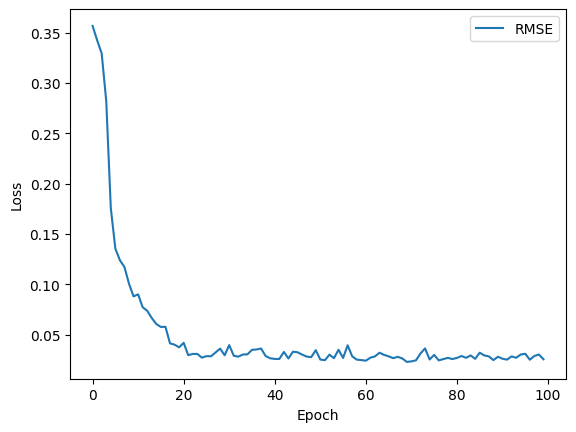

In [22]:
# plot losses
plt.plot(losses_train, label='RMSE')
#plt.plot(losses_val, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_wind_1h_total.png')
plt.show()



In [21]:
total_solar = np.concatenate((solar_data, solar_data_val), axis=0)
total_solar_X, total_solar_y = move_sliding_window(total_solar, WINDOW_SIZE, range(11), 0)
total_solar_dataset = SolarDataset(total_solar_X, total_solar_y)
dataloader_solar_total = DataLoader(total_solar_dataset, batch_size=32, shuffle=False, drop_last=True)


(26279, 25, 11) (26279, 1)


In [22]:
#Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 64, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
BAT_SIZE = 64
HIDDEN_SIZE = 64
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
N_EPOCHS = 100
DROP_PROB = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip_param = 2

solar_1h_model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(solar_1h_model.parameters(), lr=lr, weight_decay=0.0001)

c:\Users\Béla\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
solar_1h_model, losses_train_solar_1h = train_model(solar_1h_model, dataloader_solar_total, None, criterion, optimizer, num_epochs=N_EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.5343758915794897
Epoch 1, train loss: 0.5343758915794897
Epoch 2, train loss: 0.5343758915794897
Epoch 3, train loss: 0.5343758915794897
Epoch 4, train loss: 0.5343758915794897


KeyboardInterrupt: 

In [ ]:
torch.save(solar_1h_model.state_dict(), 'total_solar_1h_model.pth')

In [ ]:
plt.plot(losses_train_solar_1h, label='RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_solar_1h_total.png')
plt.show()


In [ ]:
def move_sliding_window_2(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [ ]:
total_solar_24h_X, total_solar_24h_y = move_sliding_window_2(total_solar, WINDOW_SIZE, range(11), 0, forecast_horizon=24)
total_solar_24h_dataset = SolarDataset(total_solar_24h_X, total_solar_24h_y)
dataloader_solar_total_24h = DataLoader(total_solar_24h_dataset, batch_size=32, shuffle=False, drop_last=True)


In [ ]:
#est parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZE = 16
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
DROP_PROB = 0.5
grad_clip_param = 2

model_solar_24h = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
